In [2]:
using Dates
using JuMP
using CSV
using DataFrames
using LinearAlgebra
using Distributions
using Statistics
using Dates
using Plots
ENV["COLUMNS"] = 200;
include("COVIDResourceAllocation.jl")
using .COVIDResourceAllocation

In [3]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
start_date = Date(2020, 3, 30)
end_date   = Date(2020, 6, 30)
travel_threshold_hours = 4.0

adj = adjacencies(states, level=:state, source=:google, threshold=travel_threshold_hours);

In [4]:
hospitalized_days = 14
forecast_initial = forecast(
    states, start_date-Dates.Day(1), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)[:]
forecast_active = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_admitted = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_discharged = forecast(
    states, start_date-Dates.Day(hospitalized_days), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
);

In [5]:
pct_nurses_available = 0.5
patients_per_nurse_covid = 2.5
nurse_hrs_per_week_covid = 36
pct_beds_available = 0.25

beds = n_beds(states, bed_type=:all, pct_beds_available=pct_beds_available)

N = length(states);
T = (end_date - start_date).value + 1

forecast_discharged = hcat(forecast_discharged, zeros(Float32, N, T - hospitalized_days))

@show nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7
@show nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid

@show nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid;

nurses = n_nurses(states) * Float32(pct_nurses_available);

nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7 = 5.142857142857143
nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid = 4.666666666666666
nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid = 1.8666666666666665


In [9]:
isolation_spot = vec([7,8])
model = patient_nurse_allocation_new(
    beds,
    forecast_initial,
    forecast_discharged,
    forecast_admitted,
    nurses,
    adj,
    isolation_spot,
    los = Exponential(100),
    verbose=true
)
sentp = value.(model[:sentnurses])
sentn = value.(model[:sentpatients])
println("termination status: ", termination_status(model))
println("solve time: ", round(solve_time(model), digits=3), "s")
println("objective function value: ", round(objective_value(model), digits=3))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-21
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 22.6.0 22G513)

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 35154 rows, 24552 columns and 5775207 nonzeros
Model fingerprint: 0x2b2fb725
Coefficient statistics:
  Matrix range     [4e-01, 2e+00]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+04]
Presolve removed 29104 rows and 6701 columns
Presolve time: 2.19s
Presolved: 6050 rows, 17851 columns, 4458329 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...


Barrier performed 0 iterations in 5.09 seconds (3.68 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
    5257    1.50

In [10]:
results = PatientAllocationResults.results_all(sentp, beds, forecast_initial, forecast_admitted, forecast_discharged, states, start_date, hospitalized_days)
println("Total overflow: ", results.total_overflow)
println("Average load: ", results.average_load)

Total overflow: 0.0
Average load: -360.1231


In [11]:
results.summary_table

Row,location,total_sent,total_received,overflow,overall_load,overflow_nosent,overall_load_nosent
,String,Float64,Float64,Float64,Float64,Float32,Float32
1,CT,33606.9,32465.5,0.0,-5.48349,0.0,-5.59563
2,DE,8061.92,9705.9,557.746,-1.46198,0.0,-1.88425
3,MA,16194.9,28791.5,0.0,-2.10013,0.0,-2.49819
4,MD,34751.0,33208.8,0.0,-4.17781,0.0,-4.36704
5,ME,2845.86,2355.36,0.0,-0.393468,0.0,-0.359982
6,NH,7897.35,7413.85,0.0,-1.29917,0.0,-1.32628
7,NJ,2314.87,651.872,0.0,-6.84916,0.0,-6.79965
8,NY,11233.9,6347.19,248.064,-4.98159,0.0,-4.92251
9,PA,44099.1,40551.8,0.0,-1.77684,0.0,-1.79223


In [12]:
results.sent_matrix_table

Row,state,CT,DE,MA,MD,ME,NH,NJ,NY,PA,RI,VT
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,CT,0.0,0.0,1953.23,9777.32,0.0,1242.91,651.872,0.0,15424.5,4246.45,310.534
2,DE,2143.8,0.0,692.402,1807.19,0.0,931.222,0.0,132.605,0.0,2170.32,184.375
3,MA,11054.1,1777.52,0.0,2038.4,110.772,13.4113,0.0,0.0,965.535,55.4848,179.677
4,MD,4176.31,1853.52,232.496,0.0,324.728,3173.4,0.0,3084.5,19905.0,2000.58,0.451297
5,ME,22.6879,647.796,605.831,216.402,0.0,1184.76,0.0,0.0,0.0604377,0.0,168.32
6,NH,483.5,525.101,3245.25,0.0,300.839,0.0,0.0,967.0,744.078,989.115,642.471
7,NJ,778.812,356.905,-1.13687e-13,345.282,19.7822,0.0,0.0,0.0,771.823,42.2683,0.0
8,NY,2229.83,1618.45,1868.81,678.345,1534.42,43.997,0.0,0.0,1207.59,1422.2,630.287
9,PA,8590.43,402.071,12636.1,15930.3,17.1065,805.762,0.0,1523.41,0.0,3963.29,230.626


In [13]:
println("First day:")
filter(row -> row.date == start_date, results.complete_table)

First day:


Row,location,date,sent,received,new_patients,active_patients,active_patients_nosent,capacity,overflow,load,overflow_nosent,load_nosent,sent_to,sent_from
,String,Date,Float64,Float64,Float32,Float64,Float32,Float32,Float64,Float64,Float32,Float32,Any,Any
1,CT,2020-03-30,1025.15,0.0,3.70665,217.865,217.865,1840.25,0.0,0.118389,0.0,0.118389,"[(""NH"", 373.281), (""NJ"", 651.872)]",[]
2,DE,2020-03-30,132.605,0.0,0.0,20.7745,20.7745,506.75,0.0,0.0409956,0.0,0.0409956,"[(""NY"", 132.605)]",[]
3,MA,2020-03-30,1542.25,0.0,4.0887,96.6341,96.6341,3997.75,0.0,0.0241721,0.0,0.0241721,"[(""MD"", 1542.25)]",[]
4,MD,2020-03-30,3084.5,1542.25,0.0,1675.75,133.496,2228.75,0.0,0.751877,0.0,0.0598971,"[(""NY"", 3084.5)]","[(""MA"", 1542.25)]"
5,ME,2020-03-30,278.368,0.0,0.0,12.9188,12.9188,668.0,0.0,0.0193396,0.0,0.0193396,"[(""NH"", 110.219), (""VT"", 168.149)]",[]
6,NH,2020-03-30,967.0,483.5,0.0,500.463,16.9628,584.5,0.0,0.856224,0.0,0.029021,"[(""NY"", 967.0)]","[(""CT"", 373.281), (""ME"", 110.219)]"
7,NJ,2020-03-30,0.0,651.872,19.1623,1687.4,1035.53,4553.25,0.0,0.370593,0.0,0.227427,[],"[(""CT"", 651.872)]"
8,NY,2020-03-30,0.0,6305.65,117.661,10654.3,4348.66,10406.2,248.064,1.02384,0.0,0.41789,[],"[(""DE"", 132.605), (""MD"", 3084.5), (""NH"", 967.0), (""PA"", 1481.88), (""RI"", 294.169), (""VT"", 345.5)]"
9,PA,2020-03-30,1481.88,0.0,3.7197,197.962,197.962,7980.25,0.0,0.0248065,0.0,0.0248065,"[(""NY"", 1481.88)]",[]


In [14]:
s = "NJ"
filter(row -> row.location == s, results.complete_table)

Row,location,date,sent,received,new_patients,active_patients,active_patients_nosent,capacity,overflow,load,overflow_nosent,load_nosent,sent_to,sent_from
,String,Date,Float64,Float64,Float32,Float64,Float32,Float32,Float64,Float64,Float32,Float32,Any,Any
1,NJ,2020-03-30,0.0,651.872,19.1623,1687.4,1035.53,4553.25,0.0,0.370593,0.0,0.227427,[],"[(""CT"", 651.872)]"
2,NJ,2020-03-31,0.0,0.0,27.2138,1172.35,520.48,4553.25,0.0,0.257476,0.0,0.11431,[],[]
3,NJ,2020-04-01,0.0,0.0,34.3332,596.963,-54.9094,4553.25,0.0,0.131107,0.0,-0.0120594,[],[]
4,NJ,2020-04-02,0.0,0.0,45.6683,-34.589,-686.461,4553.25,0.0,-0.00759655,0.0,-0.150763,[],[]
5,NJ,2020-04-03,346.413,0.0,61.6248,-717.432,-1369.3,4553.25,0.0,-0.157565,0.0,-0.300731,"[(""DE"", 346.413)]",[]
6,NJ,2020-04-04,423.609,0.0,80.9276,-1789.0,-2094.46,4553.25,0.0,-0.392905,0.0,-0.459991,"[(""CT"", 361.363), (""DE"", 10.4921), (""ME"", 9.48604), (""RI"", 42.2683)]",[]
7,NJ,2020-04-05,297.129,0.0,103.17,-2976.56,-2858.41,4553.25,0.0,-0.653721,0.0,-0.627773,"[(""ME"", 9.28697), (""PA"", 287.842)]",[]
8,NJ,2020-04-06,184.153,0.0,131.107,-4062.67,-3647.39,4553.25,0.0,-0.892258,0.0,-0.801053,"[(""CT"", 180.753), (""PA"", 3.39962)]",[]
9,NJ,2020-04-07,0.0,0.0,166.104,-5049.74,-4450.31,4553.25,0.0,-1.10904,0.0,-0.977392,[],[]


In [15]:
results.sent_to

Dict{String, Vector{String}} with 11 entries:
  "RI" => ["CT", "DE", "MA", "MD", "ME", "NY", "PA", "VT"]
  "NY" => ["CT", "DE", "MA", "MD", "ME", "NH", "PA", "RI", "VT"]
  "ME" => ["CT", "DE", "MA", "MD", "NH", "PA", "VT"]
  "NJ" => ["CT", "DE", "MD", "ME", "PA", "RI"]
  "DE" => ["CT", "MA", "MD", "NH", "NY", "RI", "VT"]
  "MD" => ["CT", "DE", "MA", "ME", "NH", "NY", "PA", "RI", "VT"]
  "NH" => ["CT", "DE", "MA", "ME", "NY", "PA", "RI", "VT"]
  "CT" => ["MA", "MD", "NH", "NJ", "PA", "RI", "VT"]
  "MA" => ["CT", "DE", "MD", "ME", "NH", "PA", "RI", "VT"]
  "PA" => ["CT", "DE", "MA", "MD", "ME", "NH", "NY", "RI", "VT"]
  "VT" => ["CT", "DE", "MA", "MD", "ME", "NH", "NY", "PA", "RI"]

## Plotting overflow over time for historical data

In [18]:
# note I exlcuded the initial patients
net_patients_per_day = forecast_active-forecast_discharged+forecast_admitted;

In [19]:
nurses_p_day = (1/nurse_days_per_patient_day_covid)*pct_nurses_available*Matrix(DataFrame(repeat(nurses, 1, size(net_patients_per_day)[2]), :auto))
beds_p_day = pct_beds_available*Matrix(DataFrame(repeat(beds, 1, size(net_patients_per_day)[2]), :auto))
capacity = nurses_p_day+beds_p_day;

In [20]:
start_date = Date(2020, 3, 30)
end_date   = Date(2020, 6, 30)
overflow = net_patients_per_day - capacity
overflows_p_hosp = vec(sum(overflow, dims=1));

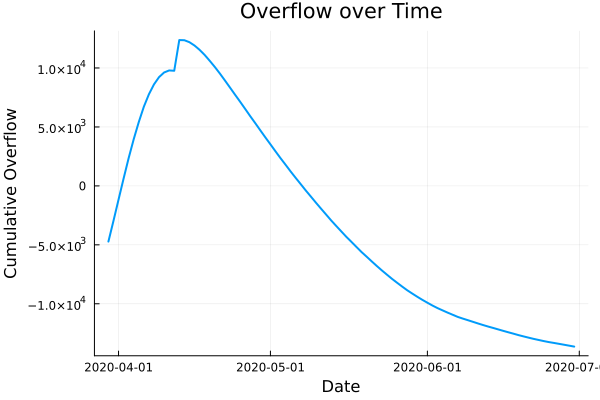

In [21]:
date_range = start_date:end_date
gr()
plot(date_range, overflows_p_hosp,
     xlabel = "Date",
     ylabel = "Cumulative Overflow",
     title = "Overflow over Time",
     legend = false,
     linewidth = 2,fmt=:png) 

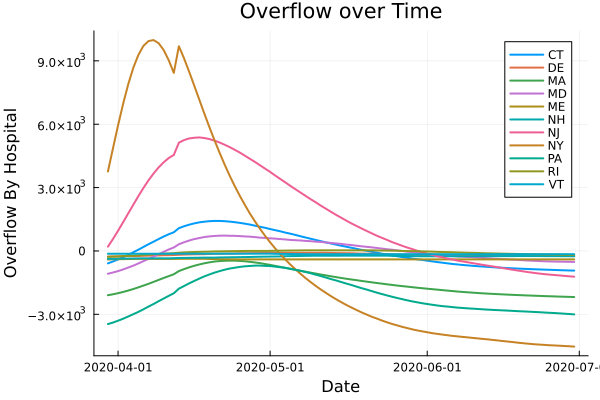

In [22]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

plot(date_range, [vec(overflow[i,:]) for i in 1:size(overflow)[1]],
     xlabel = "Date",
     ylabel = "Overflow By Hospital",
     title = "Overflow over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)


## Shortage Plots

In [23]:
net_shortage = net_patients_per_day*nurse_days_per_patient_day_covid - nurses_p_day*pct_nurses_available;
net_shortage_p_hosp = vec(sum(net_shortage, dims=1));

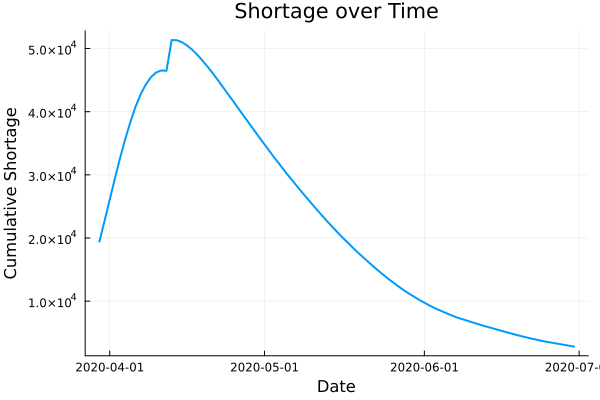

In [25]:
gr()
plot(date_range, net_shortage_p_hosp,
     xlabel = "Date",
     ylabel = "Cumulative Shortage",
     title = "Shortage over Time",
     legend = false,
     linewidth = 2,fmt=:png) 

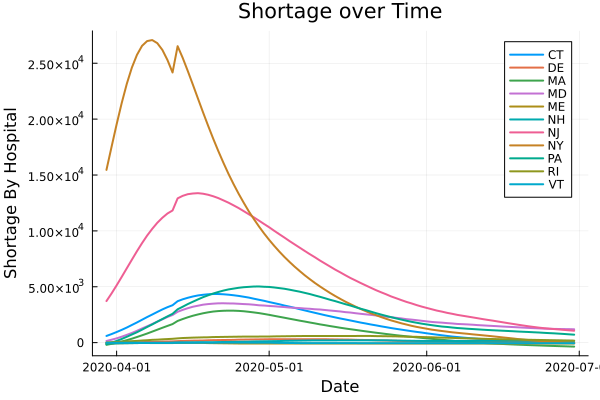

In [27]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

plot(date_range, [vec(net_shortage[i,:]) for i in 1:size(net_shortage)[1]],
     xlabel = "Date",
     ylabel = "Shortage By Hospital",
     title = "Shortage over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)